**1. Open the ATL06 files and run the rift detector.** Put the needed info in a dictionary, save the whole thing to file.

In [33]:
import arc
import pickle

# Data sets that I've downloaded: 'brunt', 'milne', 'bigbrunt','amery','larsenc', 'brunt-riiser-ekstrom'

shelf_name = 'brunt-riiser-ekstrom'
atl06_file_name = shelf_name + '_atl06.pickle'
arc.ingest('/Users/lipovsky/is2-data/%s'%shelf_name,atl06_file_name)

# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)

# Find the rifts
rift_obs = arc.get_rifts(atl06_data)

# Store the rifts in a dataframe
import pandas as pd
rift_obs=pd.DataFrame(rift_obs)

Found 1258 files in the provided directory
Time to read the H5 files:  0:02:39.748812


/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


 
Found 111817 rifts.
Time to detect rifts: 0:06:46.729324


In [34]:
# Load bedmachine ice mask
# 0 = ocean, 1 = ice-free land, 2 = grounded ice, 3 = floating ice, 4 = lake Vostok
from netCDF4 import Dataset
import numpy as np
from scipy.interpolate import interp2d
maskfile = '/Users/lipovsky/Downloads/BedMachineAntarctica_2019-11-05_v01.nc'
fh = Dataset(maskfile, mode='r')
x = fh.variables['x'][:]
y = np.flipud(fh.variables['y'][:])
mask = np.flipud(fh.variables['mask'][:])
f = interp2d(x, y, mask)
rift_mask = [float(f(XX,YY)) for XX,YY in zip(rift_obs['x-centroid'],rift_obs['y-centroid'])]
rift_obs['mask']=rift_mask

**Plot the rift catalog**

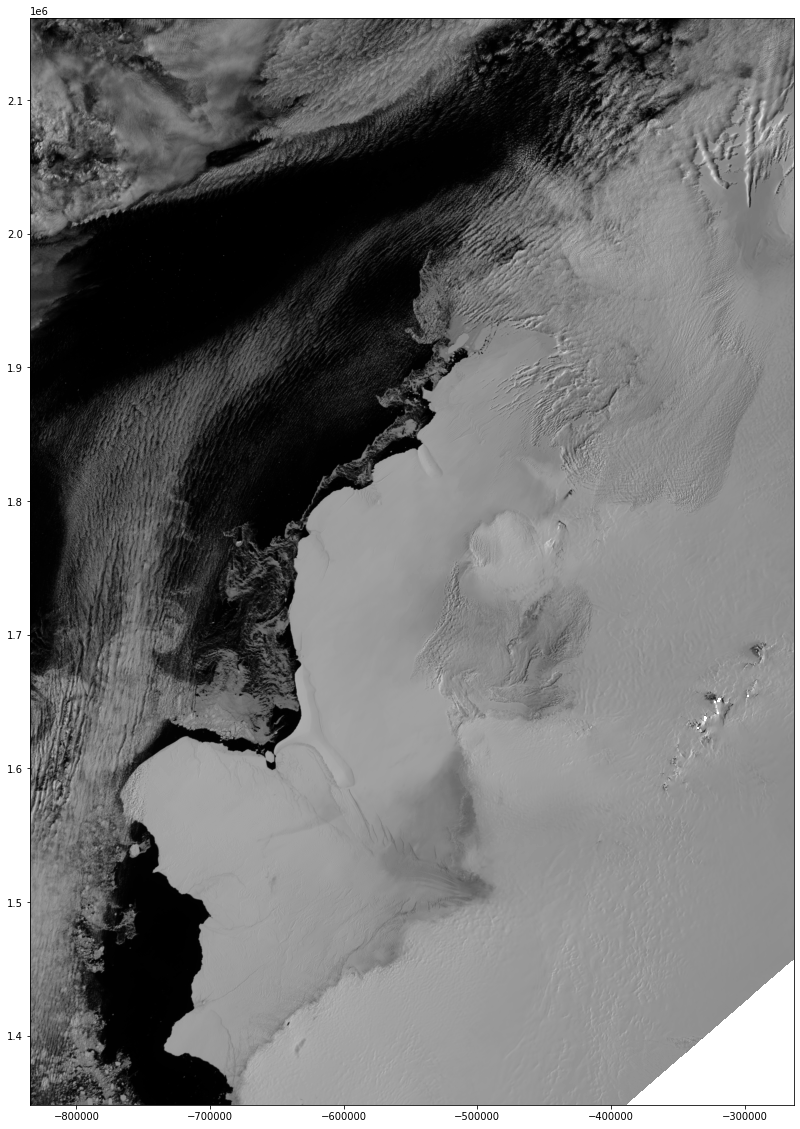

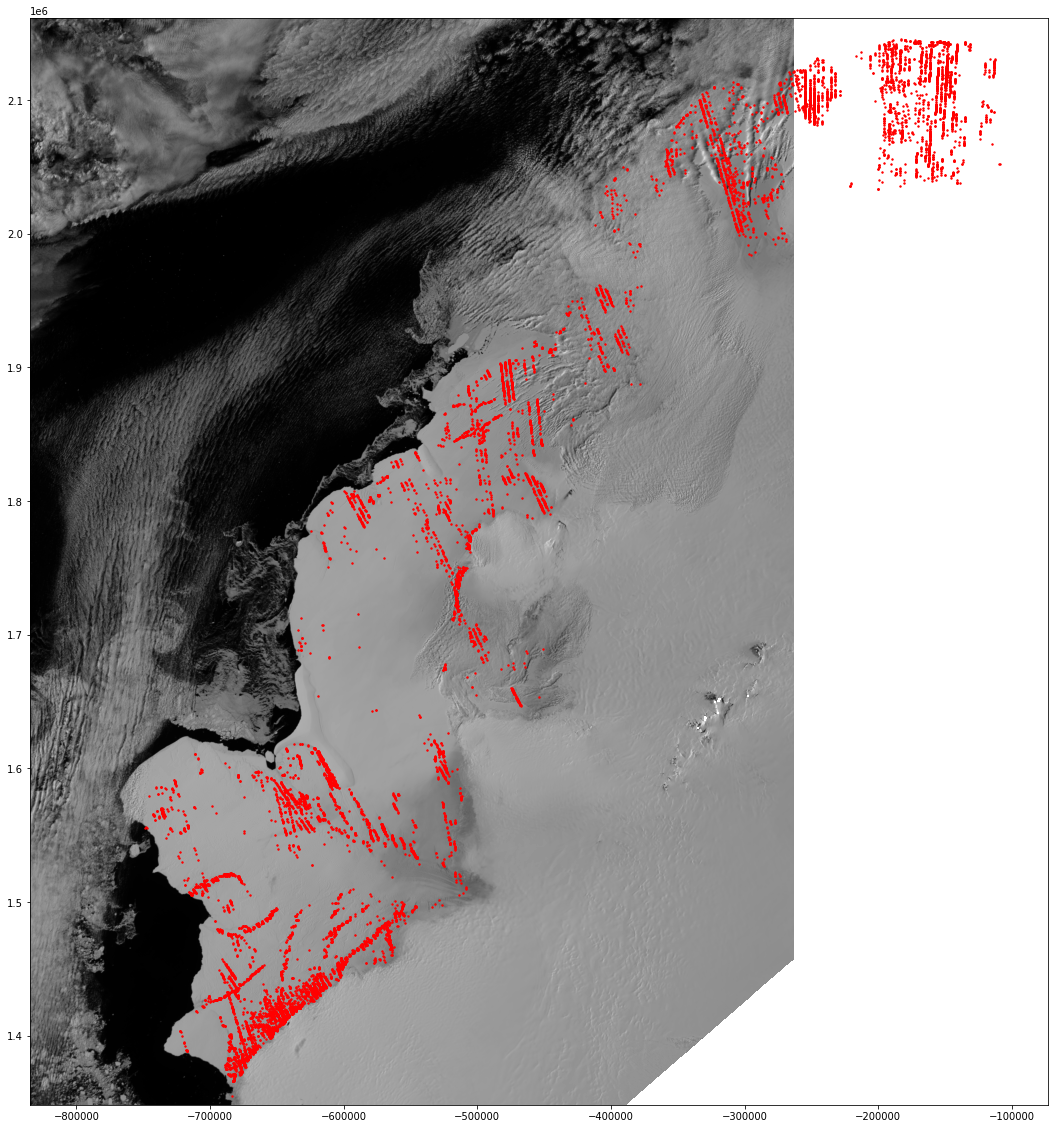

In [36]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show







# Plot just imagery
fig,ax = plt.subplots(figsize=(20,20))
image_file = '/Users/lipovsky/Downloads/riise_2020028_1615_modis_ch02.tif'
# image_file='/Users/lipovsky/Downloads/amery_2020086_0305_modis_ch02.tif'
sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax)
plt.show()








# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="gray",ax=ax2)

# Only plot rifts smaller than a certain width
w_max = 100e3

ax2.scatter(rift_obs[rift_obs['mask']==3]['x-centroid'] ,
                rift_obs[rift_obs['mask']==3]['y-centroid'] ,
                s=2,c='r')

# ax2.scatter(rift_obs[rift_obs["width"]<w_max]['x-centroid'] ,
#                 rift_obs[rift_obs["width"]<w_max]['y-centroid'] ,
#                 s=2,c='r')

#                 s=rift_obs[rift_obs["width"]<w_max]['width'], c='r',alpha=0.25)
# plt.ylim([1.35e6,1.45e6])
# plt.xlim([-7.5e5,-6.0e5])
plt.show()

**Verify the results.**  Plot the rift detections along with the ATL06 data.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
atl06_data=pd.DataFrame(atl06_data)


indices = np.unique(rift_obs["data_row"])
n=len(indices)
fig,ax=plt.subplots(figsize=(20,5))

for i in range(1,n):
    index = indices[i]
    if atl06_data.iloc[index]["rgt"] != 657:
        continue

#     d = np.sqrt(atl06_data.iloc[index]["x"]**2 + atl06_data.iloc[index]["y"]**2)
    d = atl06_data.iloc[index]["x_atc"]
    h = atl06_data.iloc[index]["h"] - atl06_data.iloc[index]["geoid"]

    # plt.subplot(n,1,i)
    plt.scatter(d,h,c=atl06_data.iloc[index]["quality"])
    rift_list = arc.find_the_rifts(atl06_data.iloc[index]["h"])
    output = arc.convert_to_centroid(rift_list,atl06_data.iloc[index]["x"],atl06_data.iloc[index]["y"])


    for s in rift_list:
        plt.plot(d[s[0]:s[1]],h[s[0]:s[1]],'-or')
    plt.title('RGT: %i, Beam: %s, Time: %s'%(atl06_data.iloc[index]["rgt"],
                                   atl06_data.iloc[index]["beam"],
                                   atl06_data.iloc[index]["time"]))
    plt.xlabel('X_atc')
        
#     xc = np.array(output['x-centroid'])
#     yc = np.array(output['y-centroid'])
#     dc = np.sqrt(xc**2 + yc**2)
#     for dd,ww in zip(dc,output['width']):
#         xcoords = (dd-ww/2,dd+ww/2)-d[0]
#         plt.plot( xcoords, (0,0),'-ob')
#     #     plt.xlim((0,2e3))

    plt.ylim((-20,100))
    plt.grid()
    fig.savefig('figures_brunt/plot%i.png'%i)    
    fig.clf()

<Figure size 1440x360 with 0 Axes>

**Verify that we loaded the data correctly** by making a plot of the ATL06 data

In [1]:
# import matplotlib.pyplot as plt
# import cartopy
# import cartopy.crs as ccrs
# %matplotlib inline
# from datetime import datetime

# ttstart = datetime.now()
# fig = plt.figure(figsize=[12, 12])
# # ax  = plt.subplot(projection=ccrs.SouthPolarStereo())
# # ax  = plt.subplot(projection=ccrs.NorthPolarStereo(central_longitude=-81.0))
# ax  = plt.subplot(projection=ccrs.PlateCarree())

# # ax.coastlines(resolution='50m')
# # ax.add_feature(cartopy.feature.LAND)

# ax.gridlines(draw_labels=True, dms=True ,  x_inline=False, y_inline=False)

# thr = 4
# sig_thr = 1


# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# lon_formatter = LongitudeFormatter(number_format='.1f',
#                                    degree_symbol='',
#                                    dateline_direction_label=True)
# lat_formatter = LatitudeFormatter(number_format='.1f',
#                                   degree_symbol='')
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)



# for lat, lon, h, q, r in zip(atl06_data['lat'], 
#                             atl06_data['lon'], 
#                             atl06_data['h'], 
#                             atl06_data['quality'],
#                             atl06_data['rgt']):
#     sc = ax.scatter(lon[q==0],lat[q==0],
#                     c=h[q==0],s=1,vmin=15,vmax=30,alpha=0.5,
#                     transform=ccrs.PlateCarree())
#     if r==95:
#         sc = ax.scatter(lon[q==0],lat[q==0],
#                     c='r',s=1,vmin=15,vmax=30,alpha=0.5,
#                     transform=ccrs.PlateCarree())

# # for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
# #                             atl06_data['lon'][0:1000], 
# #                             atl06_data['h'], 
# #                             atl06_data['h_sig']):
# #     sc = ax.scatter(lon[(h>thr)&(sig<sig_thr)],lat[(h>thr)&(sig<sig_thr)],
# #                     c=h[(h>thr)&(sig<sig_thr)],s=1,vmin=0,vmax=30,alpha=0.5,
# #                     transform=ccrs.PlateCarree())
# plt.colorbar(sc)

# # for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
# #                             atl06_data['lon'][0:1000], 
# #                             atl06_data['h'], 
# #                             atl06_data['h_sig']):
# #     ax.plot(lon[abs(h)<thr],lat[abs(h)<thr],'.r', transform=ccrs.PlateCarree())


# plt.show()

# ttend = datetime.now()
# print('Runtime was: ', ttend - ttstart)